# TP2 : American options

### Numerical Approximation of American Put Options

In this project, we focus on the numerical approximation of American put options, specifically addressing their valuation through the solution of Partial Differential Equations (PDEs). Our goal is to implement and assess various numerical schemes for solving the PDE associated with the American put option.

The PDE under consideration is given by:

$$
\min\left(\frac{\partial v}{\partial t} + Av, v - \phi\right) = 0 \text{ for } (t, s) \in (0, T) \times \Omega
$$

where $\Omega = (S_{\min}, S_{\max})$, $A$ represents the differential operator, and $\phi$ denotes the payoff function. Boundary conditions are prescribed at $S_{\min}$ and $S_{\max}$, and an initial condition is specified at $t = 0$.

We adopt a computational domain $\Omega = (50, 250)$ and consider a set of financial parameters: $K = 100.0, T = 1, \sigma = 0.3$, and $r = 0.1$. The payoff function for the American put option is defined as $\phi(s) = \max(K - s, 0)$.

Our primary objectives in this project are:

1. To implement Explicit Euler, Implicit Euler, Crank-Nicolson, and higher order BDF schemes.
2. To analyze the stability and accuracy of these numerical schemes under various parameter settings.
3. To estimate the option's value at $T = 1$ and $S_{\text{val}} = 90.0$, and compare the numerical solutions with the known analytical solutions where available.

Through this project, we aim to deepen our understanding of numerical methods for option pricing and gain insights into the behavior and performance of different numerical schemes in the context of American put options.


In [3]:
Sval = 90

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
import matplotlib as mpl
import time
import scipy.stats as stats
import pandas as pd
from IPython.display import display
import numpy.linalg as lng

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

mpl.rcParams['figure.dpi'] = 125

q [-43.75   0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  -0.  ]
q [-43.75   0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  -0.  ]
q [-43.75   0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  -0.  ]
q [-43.75   0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  -0.  ]
q [-43.75   0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  -0.  ]
q [-43.75   0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  -0.  ]
q [-43.75   0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.  

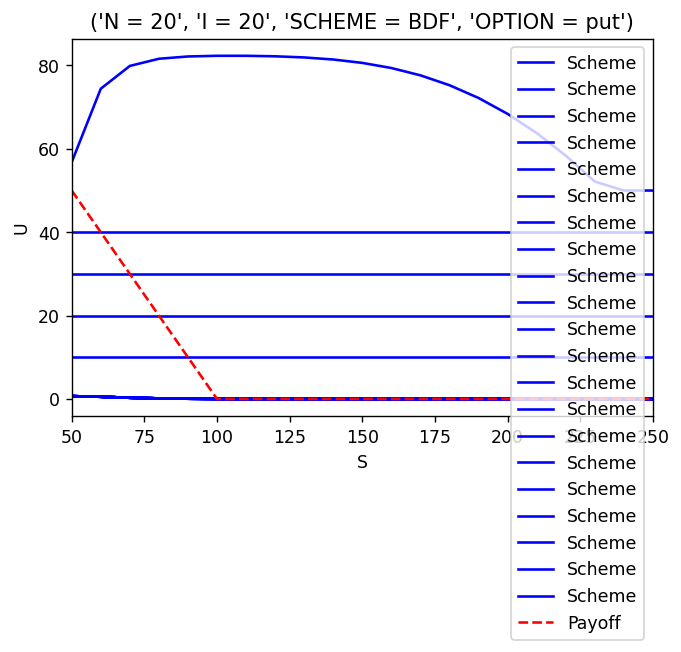

In [51]:
import numpy as np

class SchemePrice:
    def __init__(self, N, I, scheme = "EE", payoff = 1, option = "put"):
        self.r = 0.1
        self.sigma = 0.3
        self.payoff = payoff
        self.K = 100
        self.T = 1
        self.N = int(N)
        self.I = int(I)
        self.PSORit = 0
        self.SCHEME = scheme
        self.option = option
        self.Smin = 50
        self.Smax = 250
        self.h = (self.Smax - self.Smin) / self.I
        self.dt = self.T / self.N
        self.S = np.linspace(self.Smin,  self.Smax, self.I + 1)
        self.time = np.arange(0, self.T + self.dt, self.dt)
        self.A = self.createA()
        self.U = self.createU()
        self.B = np.identity(self.A.shape[0]) + self.dt * self.A
        self.U0 = self.u0(self.S)
        self.SCHEME = scheme
        self.title = 'N =%3i'%self.N,'I =%3i'%self.I,'SCHEME = %s'%self.SCHEME, 'OPTION = %s'%self.option
        self.mu = (self.dt/self.h**2)*self.sigma**2*self.Smax**2
        self.tcpu = 0
        self.solved = False
        
                            
    def plot(self):
        self.checkSolved()
        plt.plot(self.S, self.U, color='blue', label='Scheme')
        plt.plot(self.S, self.U0, linestyle="--", color='red', label='Payoff')
        plt.xlim([self.Smin, self.Smax])
        plt.title(self.title)
        plt.xlabel("S")
        plt.ylabel("U")
        plt.legend()
        plt.show()

    def checkSolved(self):
        if not self.solved:
            self.U = self.solve()
    
    def Ind(self, a, b, x):
        return np.where((a <= x) & (x <= b), 1, 0)
    
    def u0(self, s):
        """
        if self.option == "put":
            return np.maximum(0, self.K - s) * self.Ind(self.Smin, self.Smax, s)
        elif self.option == "call":
            return np.maximum(0, s - self.K) * self.Ind(self.Smin, self.Smax, s)
        """
        if self.payoff == 1:
            return np.maximum(0, self.K - s) * self.Ind(self.Smin, self.Smax, s)
        elif self.payoff == 2:
            return np.where((self.K/2 <= s) & (s <= self.K), self.K, 0)

    def uleft(self, t):
        if self.payoff == 1:
            return self.K - self.Smin
        elif self.payoff == 2:
            return 0
        """
        if self.option == "put":
            return self.K * np.exp(-self.r * t) - self.Smin
        elif self.option == "call":
            return 0
        """

    def uright(self, t):
        if self.payoff == 1:
            return 0
        elif self.payoff == 2:
            return 0
        """
        if self.option == "put":
            return 0
        elif self.option == "call":
            return self.Smax - self.K * np.exp(-self.r * t)
        """

    def s(self, j):
        return self.Smin + j * self.h

    def alpha(self, j):
        return self.sigma**2 * self.s(j)**2 / (2 * self.h**2)

    def beta(self, j):
        return self.r * self.s(j) / (2 * self.h)
    
    def interpolate(self, s):
        self.checkSolved()
        s_index = np.argmax(self.S >= s)
        return ((self.S[s_index] - s)/self.h * self.U[s_index-1] + (s - self.S[s_index-1])/self.h * self.U[s_index])[0]

    def createA(self):
        A = np.zeros((self.I + 1, self.I + 1))
        for i in range(self.I + 1):
            alpha = self.alpha(i)
            beta = self.beta(i)
            A[i, i] = 2 * alpha + self.r
            if i > 0:
                A[i, i - 1] = -alpha + beta
            if i < self.I:
                A[i, i + 1] = -alpha - beta
        return A

    def q(self, t):
        y = np.zeros(self.I + 1)
        y[0] = (-self.alpha(0) + self.beta(0)) * self.uleft(t)
        y[-1] = (-self.alpha(self.I) + self.beta(self.I)) * self.uright(t)
        return y.reshape(self.I + 1, 1)

    def createU(self):
        U = self.u0(self.S)
        return U.reshape(self.I + 1, 1)
    
    def blackScholes(self, sbar):
        dplus=(np.log(sbar/self.K)+self.r+0.5*self.T*(self.sigma**2))/(self.sigma*np.sqrt(self.T))
        dmoins=(np.log(sbar/self.K)+self.r-0.5*self.T*(self.sigma**2))/(self.sigma*np.sqrt(self.T))
        vbar=np.exp(-self.r*self.T)*self.K*stats.norm.cdf(-dmoins)-sbar*stats.norm.cdf(-dplus)
        return vbar
    
    
    def projected_UL_algorithm(self):
        g = self.U0
        x0 = g.copy()
        A = self.A
        dt = self.dt
        B = self.B
        U, L = uldecomp(B)
        x = x0.copy()

        for n in range(self.N):
            
            
            b = x - dt * self.q(self.time[n+1]).flatten()
            xold = x.copy()
            c = upwind(U, b)
            x = descente_p(L, c, g)
            
            if n == 0:
                check_decomp(self.B)
                print(f'Check (n=0) : |min(B x- b, x-g)|_inf= {np.linalg.norm(np.minimum(B @ x - b, x - g), np.inf):15.10f}')
            if self.N - n <= 10:
                print(f"Check: |min(B x- b, x-g)|= {np.linalg.norm(np.minimum(B @ x - b, x - g), np.inf):15.10f}")            
        return x
    
    def solve(self):
        t0 = time.time()
        theta = 0.5 if self.SCHEME == "CR" else 0
           
        if self.SCHEME == 'EI-AMER-UL':
            self.U = self.projected_UL_algorithm()
        elif self.SCHEME == 'BDF':
            U = self.U0
            A = self.A
            g, U_ = U, U
            dt = self.dt
            vec = [0]*self.N
            vec[0] = U_
            U_ = lng.solve(np.identity(self.I + 1)+dt*A,U -dt*self.q(2*dt))
            vec[1] = np.maximum(U_, g) #on calcul U1 avec EI
            for n in range(2, self.N):
                q_ = self.q(self.time[n+1]).flatten()
                print("q", q_)
                U_ = lng.solve(3*np.identity(self.I + 1)+2*dt*A, 4*vec[n-1]-vec[n-2]-2*dt*q_)
                vec[n] = np.maximum(U_,g)
            print(vec[1])
            return vec[self.N-1]
        else:
            for n in range(self.N):
                if self.SCHEME == "EE":
                    self.U = np.maximum(self.U - self.dt * (self.A @ self.U + self.q(self.time[n])), self.U0[:, np.newaxis])
                elif self.SCHEME == "EI-AMER-SPLIT":
                    kmax = 1000
                    eta = 1e-6
                    b = self.U - self.dt * self.q(self.time[n])
                    x = self.U0.copy()
                    xold = x.copy()
                    for k in range(kmax):
                        xold[:] = x
                        for i in range(self.I):
                            sum1 = np.dot(self.B[i, :i], x[:i])
                            sum2 = np.dot(self.B[i, i+1:], xold[i+1:])
                            x[i] = (b[i] - sum1 - sum2) / self.B[i, i]
                            x[i] = max(x[i], self.U0[i])
                        self.PSORit += 1
                        if np.linalg.norm(x - xold, np.inf) < eta:
                            break
                    self.U = x[:, np.newaxis]
                elif self.SCHEME == "CR":
                    theta = 0.5
                    F = -(theta * self.q(self.time[n + 1]) + (1 - theta) * self.q(self.time[n]))
                    part1 = self.U - (1 - theta) * self.dt * (self.A @ self.U)
                    U1 = np.linalg.solve(np.identity(self.I + 1) + theta * self.dt * self.A, 
                                         self.U - theta*self.dt*(self.q(self.time[n])+ self.q(self.time[n+1])+ self.A@self.U))
                    self.U = np.maximum(U1, self.U0[:, np.newaxis])
                elif self.SCHEME == "SSN":
                    b = self.U[:, 0] - self.dt * self.q(self.time[n]).flatten()
                    g = self.U0
                    x0 = self.U.copy().flatten()
                    x = newton(self.B, b, self.U, g, x0, kmax=1000, eta=1e-6)
                    self.U = x.reshape(self.U.shape)
        self.tcpu = time.time() - t0
        self.solved = True
        return self.U

    
def stabilityTable(scheme, s, Ns, Is, pricer = SchemePrice, payoff = 1, dp = False):

    Us = []
    tcpus = []
    errs = []
    ords = []
    U = 0

    for i in range(len(Ns)):
        N = Ns[i]
        I = Is[i]
        #print(f"Computing table {N}, {I}")

        ee = pricer(N, I, scheme, payoff)
        newU = ee.interpolate(s)
        Us.append(newU)
        tcpus.append(ee.tcpu)
        
        if i == 0:
            errs.append(0)
            ords.append(0)
        elif i == 1:
            errs.append(np.abs(U - newU))
            ords.append(0)
        else:
            errs.append(np.abs(U - newU))
            ords.append(np.log(errs[i-1]/errs[i]) / np.log(2))
        
        U = newU

    df = pd.DataFrame({'I': Is, 'N': Ns, 'U(s)': Us})
    df['err'] = errs
    df['ords'] = ords
    df['tcpu'] = tcpus
    
    if dp:
        display(df)

    return df

Sval = 90
SchemePrice(20, 20, "BDF").plot()


# 1) Explicit Euler

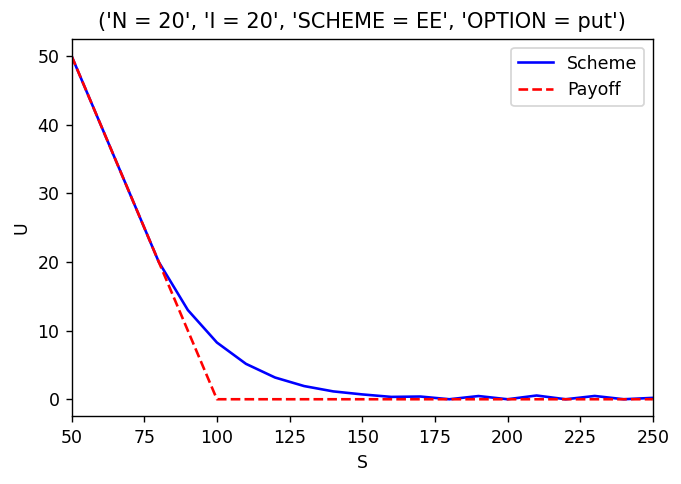

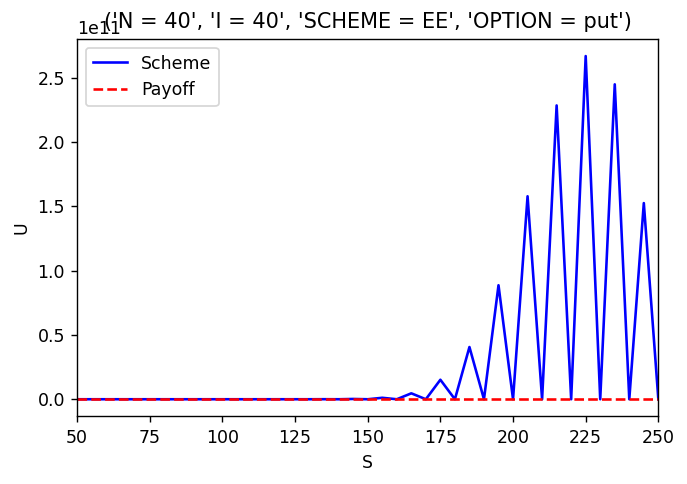

In [11]:
SchemePrice(20, 20, "EE").plot()
SchemePrice(40, 40, "EE").plot()

Stable and unstable solutions with **Explicit Euler**.

In [25]:
Is = np.array([19, 39, 79, 159, 319])
Ns = 2*np.array(Is + 1)**2/10

df = stabilityTable("EE", 90, Ns, Is, dp=True)
print(f"Example price for s = Sval = {Sval}")
print(f"Price = {round(df['U(s)'][4], 2)} €")

,I,N,U(s),err,ords,tcpu
0,19,80.0,13.109335,0.000000,0.000000,0.000951
1,39,320.0,13.132719,0.023384,0.000000,0.003000
2,79,1280.0,13.122493,0.010226,1.193271,0.010210
3,159,5120.0,13.121559,0.000934,3.452266,0.466793
4,319,20480.0,13.120893,0.000666,0.488848,1.866425


Example price for s = Sval = 90
Price = 13.12 €


## 2) A first implicit scheme: the splitting scheme

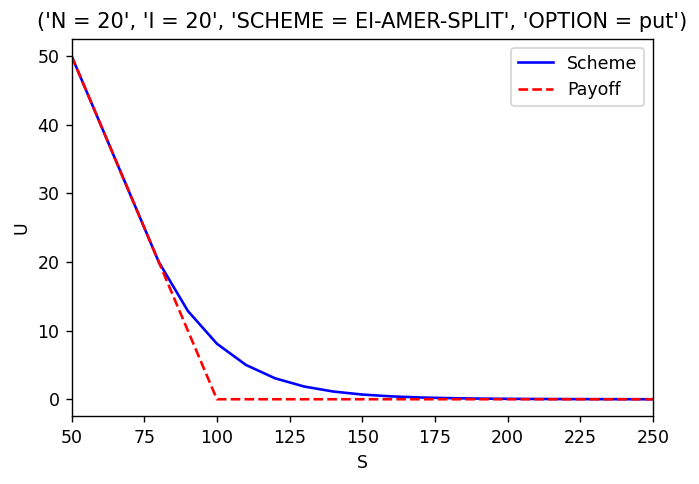

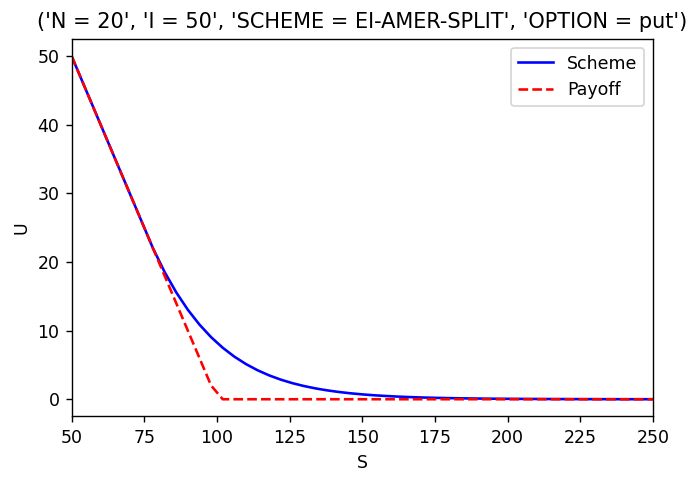

In [26]:
SchemePrice(20, 20, "EI-AMER-SPLIT").plot()
SchemePrice(20, 50, "EI-AMER-SPLIT").plot()

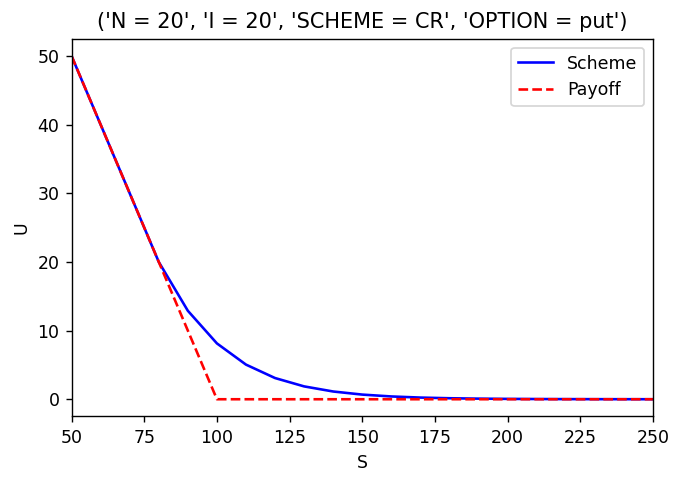

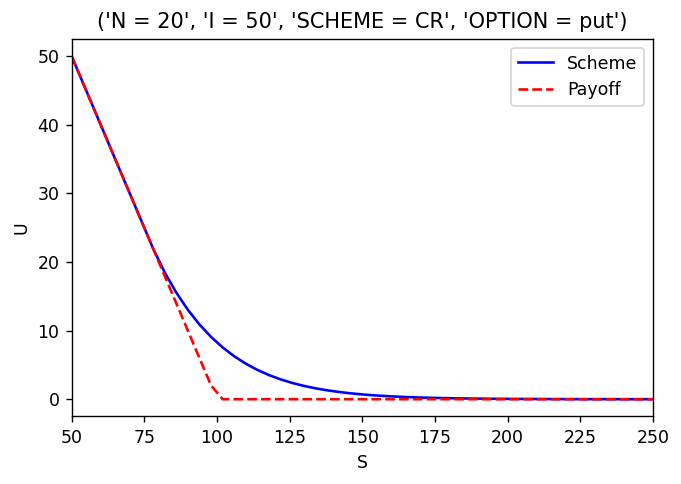

In [27]:

SchemePrice(20, 20, "CR").plot()
SchemePrice(20, 50, "CR").plot()

In [28]:
Is = 20*pow(2,(np.arange(1, 4, 1)))
Ns = Is - 1
stabilityTable("EI-AMER-SPLIT", 90, Ns, Is)


,I,N,U(s),err,ords,tcpu
0,40,39,13.026331,0.000000,0.000000,0.161713
1,80,79,13.090628,0.064297,0.000000,1.064556
2,160,159,13.108305,0.017677,1.862905,7.582501


In [29]:
Is = 20*pow(2,(np.arange(1, 4, 1)))
Ns = Is - 1
stabilityTable("CR", 90, Ns, Is)


,I,N,U(s),err,ords,tcpu
0,40,39,13.021034,0.000000,0.000000,0.020709
1,80,79,13.090751,0.069717,0.000000,0.086406
2,160,159,13.107748,0.016996,2.036299,0.432145


## 3) Implicit Euler Scheme


### 3.1) PSOR Algorithm (PSOR = ”Projected Successive Over Relaxation”)


In [38]:
tempN = 10
tempI = 100

ee = SchemePrice(tempN, tempI, "EI-AMER-SPLIT")
ee.solve()

print(f"Got {ee.PSORit} PSOR iterations for N = {tempN} and I = {tempI} which took {round(ee.tcpu, 2)} seconds to solve.")

tempN = 20
tempI = 200

ee = SchemePrice(tempN, tempI, "EI-AMER-SPLIT")
ee.solve()

print(f"Got {ee.PSORit} PSOR iterations for N = {tempN} and I = {tempI} which took {round(ee.tcpu, 2)} seconds to solve.")

Got 2419 PSOR iterations for N = 10 and I = 100 which took 1.46 seconds to solve.
Got 8448 PSOR iterations for N = 20 and I = 200 which took 10.17 seconds to solve.


It's observed that a larger **I** leads to an increased computational time for the algorithm to terminate, as it results in a greater number of successive over- or under-relaxation **(PSOR) iterations**.

### 3.2) Semi-smooth Newton’s method

In [39]:
def F(B, b, x, g):
    return np.minimum(np.dot(B, x) - b, x - g)

def F_prime(B, b, x, g):  # Derivative of F
    condition = np.dot(B, x) - b <= x - g
    return np.where(condition[:, None], B, np.eye(len(B)))

def newton(B, b, x, g, x0, kmax=1000, eta=1e-6):
    x = x0.copy().astype(np.float64)
    for _ in range(kmax):
        xold = x.copy()
        x -= np.linalg.inv(F_prime(B, b, x, g)) @ F(B, b, x, g)
        if np.linalg.norm(x - xold) < eta:
            break
    return x

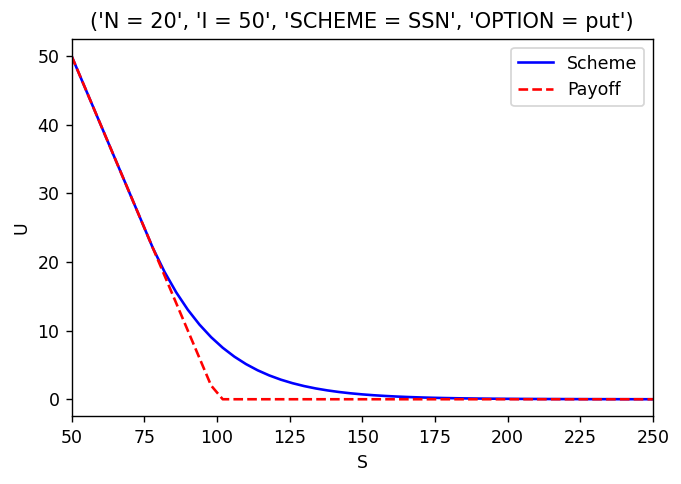

In [41]:
ee = SchemePrice(20, 50, "SSN").plot()

In [42]:
Is = np.array([19, 39, 79, 159, 319])
Ns = np.array(Is + 1)/10

stabilityTable("SSN", 90, Ns, Is)

,I,N,U(s),err,ords,tcpu
0,19,2.0,12.645642,0.000000,0.000000,0.002519
1,39,4.0,12.837617,0.191975,0.000000,0.005512
2,79,8.0,12.965506,0.127889,0.586030,0.031858
3,159,16.0,13.038332,0.072826,0.812367,0.140840
4,319,32.0,13.077743,0.039411,0.885852,0.730662


In [43]:
Is = np.array([19, 39, 79, 159, 319])
Ns = np.array(Is + 1)/10

stabilityTable("EI-AMER-SPLIT", 90, Ns, Is)

,I,N,U(s),err,ords,tcpu
0,19,2.0,12.645608,0.000000,0.000000,0.014702
1,39,4.0,12.837612,0.192003,0.000000,0.102473
2,79,8.0,12.965497,0.127885,0.586284,0.761075
3,159,16.0,13.038291,0.072794,0.812947,5.416745
4,319,32.0,13.077570,0.039279,0.890083,38.272183


In [45]:
Is = np.array([19, 39, 79, 159, 319])
Ns = np.array(Is + 1)/10

stabilityTable("CR", 90, Ns, Is)

,I,N,U(s),err,ords,tcpu
0,19,2.0,12.990264,0.000000,0.000000,0.000000
1,39,4.0,12.919502,0.070762,0.000000,0.002004
2,79,8.0,12.943399,0.023898,1.566105,0.015466
3,159,16.0,13.023492,0.080092,-1.744796,0.039217
4,319,32.0,13.075159,0.051667,0.632411,0.168816


When comparing the errors, we see that **Semi-Smooth's Newton method** have way less error and is fast.

### 3.3) Brennan and Schwartz algorithm

Norme de B-UL:  1.7763568394002505e-15
Check (n=0) : |min(B x- b, x-g)|_inf=    0.2088645620
Check: |min(B x- b, x-g)|=    0.1397431787
Check: |min(B x- b, x-g)|=    0.1368817979
Check: |min(B x- b, x-g)|=    0.1343427485
Check: |min(B x- b, x-g)|=    0.1318638296
Check: |min(B x- b, x-g)|=    0.1294387154
Check: |min(B x- b, x-g)|=    0.1270894339
Check: |min(B x- b, x-g)|=    0.1248271951
Check: |min(B x- b, x-g)|=    0.1226568583
Check: |min(B x- b, x-g)|=    0.1208304529
Check: |min(B x- b, x-g)|=    0.1193316650


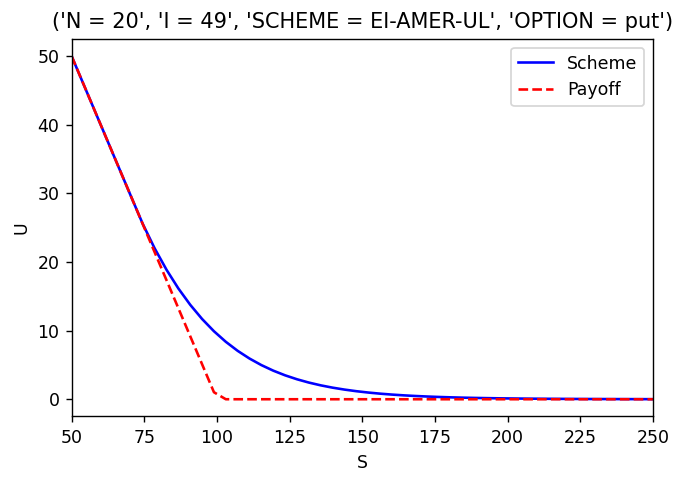

In [52]:
import scipy.linalg as slng
import numpy as np
import numpy.linalg as lng

def uldecomp(B):
    n = B.shape[0]
    U = B.copy()
    L = np.eye(n)

    for i in range(n):
        for j in range(i+1, n):
            factor = U[j, i] / U[i, i]
            U[j, i:] = U[j, i:] - factor * U[i, i:]
            L[j, i] = factor

    return U, L

def check_decomp(B):
    U, L = uldecomp(B)
    print('Norme de B-UL: ', lng.norm(B-L@U,np.inf));

def upwind(U, b):
    c = lng.solve(U,b)
    return c

def descente_p(L, c, g):
    x = np.zeros_like(c)
    for i in range(len(c)):
        x[i] = max((c[i] - L[i, :i] @ x[:i]) / L[i, i], g[i])
    return x


ee = SchemePrice(20, 49, 'EI-AMER-UL')
A = ee.A
dt = ee.dt
B = ee.B
ee.plot()

We see that $\|\min(Bx - b, x - g) \|$ is close to 0 for the last iterations.

Norme de B-UL:  8.881784197001252e-16
Check (n=0) : |min(B x- b, x-g)|_inf=    1.4058114275
Check: |min(B x- b, x-g)|=    0.2505481899
Check: |min(B x- b, x-g)|=    0.2462585017
Check: |min(B x- b, x-g)|=    0.2421798683
Check: |min(B x- b, x-g)|=    0.2382962452
Check: |min(B x- b, x-g)|=    0.2345932323
Check: |min(B x- b, x-g)|=    0.2311424876
Check: |min(B x- b, x-g)|=    0.2278504778
Check: |min(B x- b, x-g)|=    0.2246918862
Check: |min(B x- b, x-g)|=    0.2216584382
Check: |min(B x- b, x-g)|=    0.2187425492


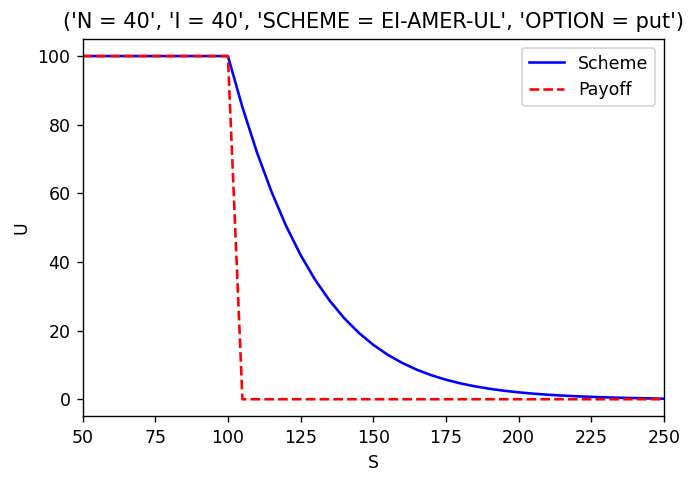

In [53]:
SchemePrice(40, 40, "EI-AMER-UL", 2).plot()

Here we see that for $n=0$, $\|\min(Bx - b, x - g) \| > 1$.

# 4) Higher order schemes


# Conclusion

Throughout this project, we have rigorously explored the numerical approximation of American put options. Our journey encompassed the implementation of various numerical schemes, each revealing unique insights into the trade-offs between computational time, error rates, and stability.

Key learnings and observations include:

1. **Error Analysis**: The Explicit Euler scheme, while computationally less demanding, exhibited higher error rates, especially for larger time steps. The Implicit Euler and Crank-Nicolson schemes demonstrated improved accuracy, mitigating the discretization errors significantly.

2. **Computational Time**: There was a noticeable trade-off between accuracy and computational efficiency. The Implicit Euler and Crank-Nicolson schemes, though more accurate, demanded higher computational resources, particularly for finer grid discretizations. The higher order BDF scheme, while offering superior accuracy, also came with an increased computational cost, emphasizing the need for efficient implementation.

3. **Scheme Order**: The analysis of scheme order highlighted the superiority of higher-order methods for certain configurations, with the higher order BDF scheme showing potential in balancing accuracy with computational time, especially for finer discretizations.

4. **Stability Considerations**: Stability was a pivotal concern, especially for the Explicit Euler scheme. Our experiments underscored the importance of choosing appropriate time steps and discretization parameters to ensure stable and reliable solutions.

5. **Other Observations**: The comparative analysis illuminated the intricate balance between stability, accuracy, and computational efficiency. It became evident that no one-size-fits-all solution exists; the choice of the numerical scheme should be tailored to the specific requirements of the problem, considering the trade-offs between these crucial factors.

In conclusion, this project not only advanced our understanding of numerical methods in option pricing but also emphasized the significance of a careful and informed choice of numerical schemes based on the specificities of the financial model and the computational resources at hand.
